# Feature Testing Notebook

**Interactive workflow for testing linguistic features**

Structure:
1. Load Data
2. Define Feature Extractor
3. Extract Feature from Corpus
4. Compare Groups Statistically
5. Visualize Results

---

## Setup: Import Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## Configure Paths

In [80]:
# === YOUR PROJECT PATHS ===
CORPUS_DIR = "/home/albere/compling/data/processed"
METADATA_FILE = "/home/albere/compling/data/docs/metadata.csv"
OUTPUT_DIR = "/home/albere/compling/data/results/feature_tests"

# Create output directory if needed
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Paths configured")
print(f"  Corpus: {CORPUS_DIR}")
print(f"  Metadata: {METADATA_FILE}")
print(f"  Output: {OUTPUT_DIR}")

✓ Paths configured
  Corpus: /home/albere/compling/data/processed
  Metadata: /home/albere/compling/data/docs/metadata.csv
  Output: /home/albere/compling/data/results/feature_tests


---
## Step 1: Load Data

Load all speeches and metadata into a DataFrame

In [81]:
# Load metadata
metadata = pd.read_csv(METADATA_FILE)
print(f"✓ Loaded metadata for {len(metadata)} speeches\n")

# Load speech texts
texts = []
for idx, row in metadata.iterrows():
    filename = row['filename']
    if not filename.endswith('_cleaned.txt'):
        filename = filename.replace('.txt', '_cleaned.txt')
    
    filepath = os.path.join(CORPUS_DIR, filename)
    
    if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        texts.append(text)
    else:
        texts.append("")
        print(f"  ⚠ Warning: {filename} not found")

# Add to dataframe
metadata['text'] = texts
metadata['word_count'] = metadata['text'].apply(lambda x: len(x.split()))

print(f"✓ Loaded {len([t for t in texts if t])} speech texts")
print("\nDataset summary:")
print(metadata.groupby('category')['speaker'].count())

✓ Loaded metadata for 28 speeches

✓ Loaded 28 speech texts

Dataset summary:
category
Mainstream    14
Populist      14
Name: speaker, dtype: int64


In [82]:
# Preview data
metadata[['speaker', 'category', 'country', 'word_count']].head(10)

,speaker,category,country,word_count
0,George W. Bush,Mainstream,US,5072
1,Mitt Romney,Mainstream,US,4099
2,George W. Bush,Mainstream,US,4072
3,Mitt Romney,Mainstream,US,3386
4,John McCain,Mainstream,US,3976
5,John McCain,Mainstream,US,3840
6,Mike Pence,Mainstream,US,2998
7,Donald Trump,Populist,US,6337
8,Donald Trump,Populist,US,6851
9,Donald Trump,Populist,US,2666


---
## Step 2: Define Your Feature Extractor

**Edit this cell to test different features!**

The function should:
- Take text as input
- Return a single numerical value
- Usually normalize per 1000 words for comparability

In [83]:
 # Example 4: Collective pronouns density (us/our/ourselves)
 def my_feature_extractor(text):
     collective = ['us', 'our', 'ours', 'ourselves']
     words = text.lower().split()
     collective_count = sum(words.count(c) for c in collective)
     return (collective_count / len(words)) * 1000 if words else 0
 FEATURE_NAME = "Collective_Pronoun_Density"

### Alternative Feature Examples

Uncomment one to try it:

In [84]:
# # Example 1: Average word length
# def my_feature_extractor(text):
#     words = [w for w in text.split() if w.isalpha()]
#     return sum(len(w) for w in words) / len(words) if words else 0
# FEATURE_NAME = "Avg_Word_Length"

# # Example 2: First-person singular density
# def my_feature_extractor(text):
#     first_person = ['i', 'me', 'my', 'mine', 'myself']
#     words = text.lower().split()
#     fp_count = sum(words.count(fp) for fp in first_person)
#     return (fp_count / len(words)) * 1000 if words else 0
# FEATURE_NAME = "First_Person_Density"

# # Example 3: Collective pronouns density (us/our/ourselves)
# def my_feature_extractor(text):
#     collective = ['us', 'our', 'ours', 'ourselves']
#     words = text.lower().split()
#     collective_count = sum(words.count(c) for c in collective)
#     return (collective_count / len(words)) * 1000 if words else 0
# FEATURE_NAME = "Collective_Pronoun_Density"

---
## Step 3: Extract Feature from All Speeches

In [85]:
print(f"Extracting {FEATURE_NAME} from all speeches...\n")

# Apply feature extraction
metadata[FEATURE_NAME] = metadata['text'].apply(my_feature_extractor)

print(f"✓ Feature extracted for {len(metadata)} speeches\n")

# Show sample results
print("Sample results:")
metadata[['speaker', 'category', FEATURE_NAME]].head(10)

Extracting Collective_Pronoun_Density from all speeches...

✓ Feature extracted for 28 speeches

Sample results:


,speaker,category,Collective_Pronoun_Density
0,George W. Bush,Mainstream,17.350158
1,Mitt Romney,Mainstream,14.881678
2,George W. Bush,Mainstream,18.418468
3,Mitt Romney,Mainstream,32.782044
4,John McCain,Mainstream,15.845070
5,John McCain,Mainstream,21.614583
6,Mike Pence,Mainstream,14.676451
7,Donald Trump,Populist,11.046236
8,Donald Trump,Populist,13.720625
9,Donald Trump,Populist,19.129782


In [86]:
# Quick descriptive stats
print(f"Descriptive Statistics for {FEATURE_NAME}:")
print("=" * 60)
print(metadata.groupby('category')[FEATURE_NAME].describe())

Descriptive Statistics for Collective_Pronoun_Density:
            count       mean       std        min        25%        50%  \
category                                                                  
Mainstream   14.0  18.308694  6.118998  11.373093  14.727758  16.318643   
Populist     14.0  12.417727  3.076289   5.577914  11.110823  12.224458   

                  75%        max  
category                          
Mainstream  20.200458  32.782044  
Populist    13.758025  19.129782  


---
## Step 4: Statistical Comparison

Compare Populist vs Mainstream using t-test

In [87]:
# Split by category
populist_data = metadata[metadata['category'] == 'Populist'][FEATURE_NAME].dropna()
mainstream_data = metadata[metadata['category'] == 'Mainstream'][FEATURE_NAME].dropna()

print(f"STATISTICAL COMPARISON: {FEATURE_NAME}")
print("=" * 70)
print()

# Descriptive statistics
print(f"Populist (n={len(populist_data)}):")
print(f"  Mean:   {populist_data.mean():7.2f}")
print(f"  Median: {populist_data.median():7.2f}")
print(f"  SD:     {populist_data.std():7.2f}")
print(f"  Range:  {populist_data.min():.2f} - {populist_data.max():.2f}")
print()

print(f"Mainstream (n={len(mainstream_data)}):")
print(f"  Mean:   {mainstream_data.mean():7.2f}")
print(f"  Median: {mainstream_data.median():7.2f}")
print(f"  SD:     {mainstream_data.std():7.2f}")
print(f"  Range:  {mainstream_data.min():.2f} - {mainstream_data.max():.2f}")
print()

# T-test
t_stat, p_value = stats.ttest_ind(populist_data, mainstream_data)

# Effect size (Cohen's d)
pooled_std = np.sqrt(
    ((len(populist_data)-1) * populist_data.std()**2 + 
     (len(mainstream_data)-1) * mainstream_data.std()**2) / 
    (len(populist_data) + len(mainstream_data) - 2)
)
cohens_d = (populist_data.mean() - mainstream_data.mean()) / pooled_std

# Interpret effect size
if abs(cohens_d) < 0.2:
    effect_interpretation = "Negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "Small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "Medium"
else:
    effect_interpretation = "Large"

# Results
print("STATISTICAL TEST RESULTS:")
print("-" * 70)
print(f"Mean Difference: {populist_data.mean() - mainstream_data.mean():+7.2f}")
print(f"t-statistic:     {t_stat:7.2f}")
print(f"p-value:         {p_value:7.4f}")
print(f"Significant?     {'YES ✓' if p_value < 0.05 else 'NO ✗'} (α=0.05)")
print(f"Cohen's d:       {cohens_d:7.2f} ({effect_interpretation})")
print()

if p_value < 0.05:
    direction = "higher" if populist_data.mean() > mainstream_data.mean() else "lower"
    print(f"✓ Populist speeches have significantly {direction} {FEATURE_NAME}")
    print(f"  than mainstream speeches (p = {p_value:.4f})")
else:
    print(f"✗ No significant difference in {FEATURE_NAME} between groups")

print("=" * 70)

STATISTICAL COMPARISON: Collective_Pronoun_Density

Populist (n=14):
  Mean:     12.42
  Median:   12.22
  SD:        3.08
  Range:  5.58 - 19.13

Mainstream (n=14):
  Mean:     18.31
  Median:   16.32
  SD:        6.12
  Range:  11.37 - 32.78

STATISTICAL TEST RESULTS:
----------------------------------------------------------------------
Mean Difference:   -5.89
t-statistic:       -3.22
p-value:          0.0034
Significant?     YES ✓ (α=0.05)
Cohen's d:         -1.22 (Large)

✓ Populist speeches have significantly lower Collective_Pronoun_Density
  than mainstream speeches (p = 0.0034)


### APA-Style Reporting

Copy this text for your assignment:

In [88]:
direction = "higher" if populist_data.mean() > mainstream_data.mean() else "lower"
df = len(populist_data) + len(mainstream_data) - 2

apa_text = f"""
Populist speeches exhibited significantly {direction} {FEATURE_NAME} 
(M = {populist_data.mean():.2f}, SD = {populist_data.std():.2f}) compared to 
mainstream speeches (M = {mainstream_data.mean():.2f}, SD = {mainstream_data.std():.2f}), 
t({df}) = {t_stat:.2f}, p {'< 0.001' if p_value < 0.001 else f'= {p_value:.3f}'}, 
d = {cohens_d:.2f}.
"""

print("APA-STYLE REPORT:")
print(apa_text)

APA-STYLE REPORT:

Populist speeches exhibited significantly lower Collective_Pronoun_Density 
(M = 12.42, SD = 3.08) compared to 
mainstream speeches (M = 18.31, SD = 6.12), 
t(26) = -3.22, p = 0.003, 
d = -1.22.



---
## Step 5: Visualize Results

Create multiple visualizations

✓ Plot saved to: /home/albere/compling/data/results/feature_tests/Collective_Pronoun_Density_comparison.png


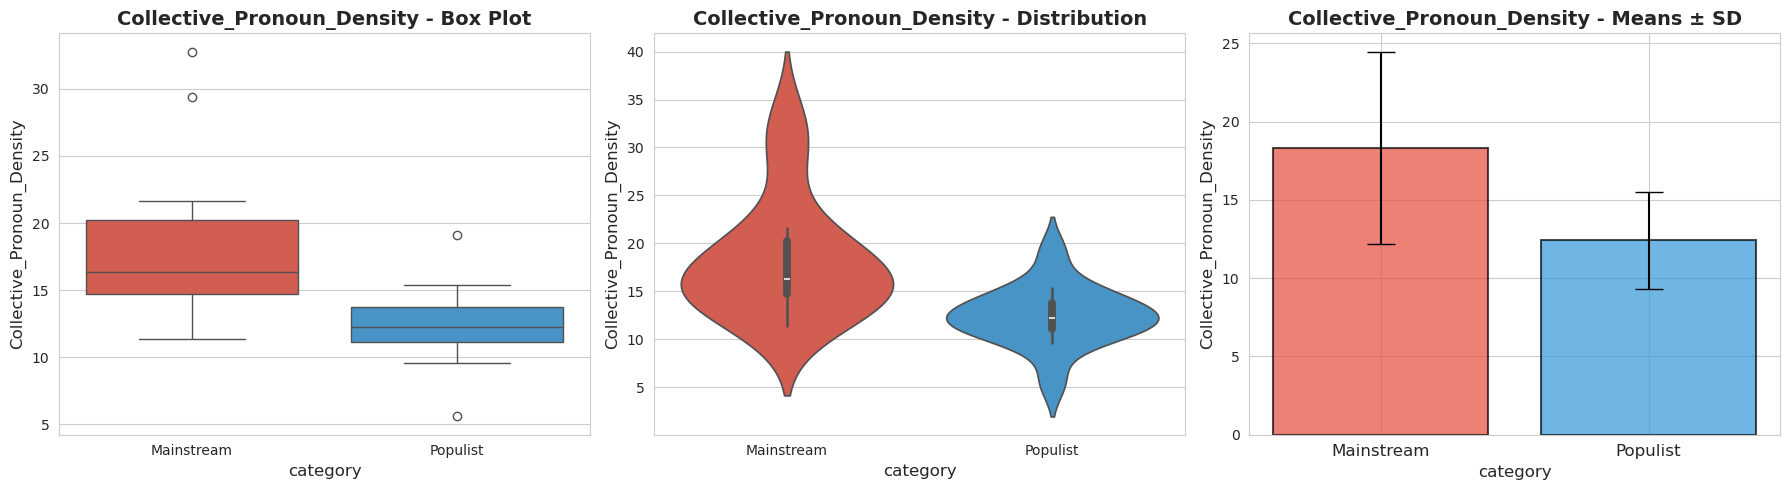

In [89]:
# Prepare data for plotting
plot_data = metadata[metadata['category'].isin(['Populist', 'Mainstream'])].copy()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Box plot
sns.boxplot(data=plot_data, x='category', y=FEATURE_NAME, hue='category', ax=axes[0],
            palette=['#e74c3c', '#3498db'], legend=False)
axes[0].set_title(f'{FEATURE_NAME} - Box Plot', fontsize=14, fontweight='bold')
axes[0].set_ylabel(FEATURE_NAME, fontsize=12)
axes[0].set_xlabel('category', fontsize=12)

# 2. Violin plot
sns.violinplot(data=plot_data, x='category', y=FEATURE_NAME, hue='category', ax=axes[1],
               palette=['#e74c3c', '#3498db'], legend=False)
axes[1].set_title(f'{FEATURE_NAME} - Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel(FEATURE_NAME, fontsize=12)
axes[1].set_xlabel('category', fontsize=12)

# 3. Bar plot with error bars
means = plot_data.groupby('category')[FEATURE_NAME].mean()
stds = plot_data.groupby('category')[FEATURE_NAME].std()

x_pos = np.arange(len(means))
axes[2].bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7,
            color=['#e74c3c', '#3498db'], edgecolor='black', linewidth=1.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(means.index, fontsize=12)
axes[2].set_title(f'{FEATURE_NAME} - Means ± SD', fontsize=14, fontweight='bold')
axes[2].set_ylabel(FEATURE_NAME, fontsize=12)
axes[2].set_xlabel('category', fontsize=12)

plt.tight_layout()

# Save figure
save_path = os.path.join(OUTPUT_DIR, f'{FEATURE_NAME}_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Plot saved to: {save_path}")

plt.show()

### Individual Speaker Plot

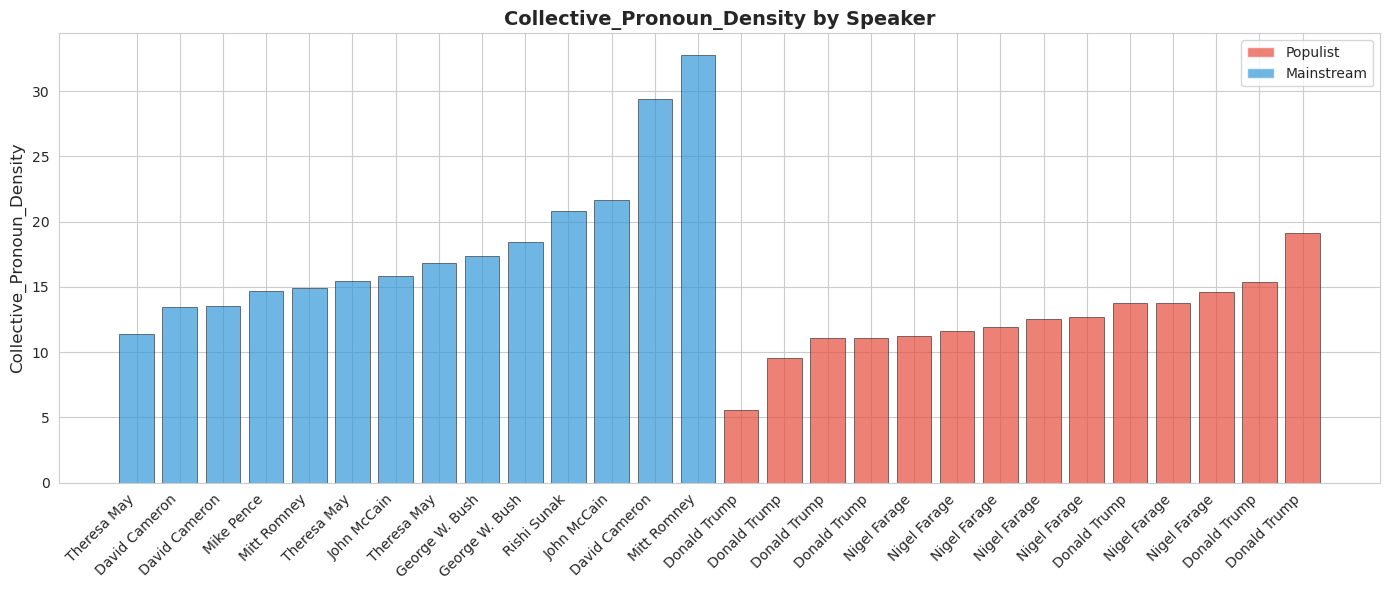

In [90]:
# Plot by individual speaker
plt.figure(figsize=(14, 6))

# Sort by category then value
plot_data_sorted = plot_data.sort_values(['category', FEATURE_NAME])

# Create colors based on category
colors = ['#e74c3c' if cat == 'Populist' else '#3498db' 
          for cat in plot_data_sorted['category']]

plt.bar(range(len(plot_data_sorted)), plot_data_sorted[FEATURE_NAME], 
        color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

plt.xticks(range(len(plot_data_sorted)), plot_data_sorted['speaker'], 
           rotation=45, ha='right')
plt.ylabel(FEATURE_NAME, fontsize=12)
plt.title(f'{FEATURE_NAME} by Speaker', fontsize=14, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', alpha=0.7, label='Populist'),
                   Patch(facecolor='#3498db', alpha=0.7, label='Mainstream')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

---
## Summary

Review the key findings

In [91]:
print("=" * 70)
print(f"SUMMARY: {FEATURE_NAME}")
print("=" * 70)
print()
print(f"Populist mean:   {populist_data.mean():7.2f}")
print(f"Mainstream mean: {mainstream_data.mean():7.2f}")
print(f"Difference:      {populist_data.mean() - mainstream_data.mean():+7.2f}")
print(f"p-value:         {p_value:7.4f}")
print(f"Significant:     {'YES ✓' if p_value < 0.05 else 'NO ✗'}")
print(f"Effect size:     {cohens_d:7.2f} ({effect_interpretation})")
print()

if p_value < 0.05:
    direction = "higher" if populist_data.mean() > mainstream_data.mean() else "lower"
    pct_diff = abs((populist_data.mean() - mainstream_data.mean()) / mainstream_data.mean() * 100)
    print(f"✓ Populist speeches have {pct_diff:.1f}% {direction} {FEATURE_NAME}")
else:
    print(f"✗ No significant difference between groups")

print("=" * 70)

SUMMARY: Collective_Pronoun_Density

Populist mean:     12.42
Mainstream mean:   18.31
Difference:        -5.89
p-value:          0.0034
Significant:     YES ✓
Effect size:       -1.22 (Large)

✓ Populist speeches have 32.2% lower Collective_Pronoun_Density


---
## Export Results

In [92]:
# Save results to CSV
results_df = metadata[['speaker', 'category', 'country', FEATURE_NAME]].copy()
results_file = os.path.join(OUTPUT_DIR, f'{FEATURE_NAME}_results.csv')
results_df.to_csv(results_file, index=False)

print(f"✓ Results saved to: {results_file}")

# Save statistical summary
summary_file = os.path.join(OUTPUT_DIR, f'{FEATURE_NAME}_summary.txt')
with open(summary_file, 'w') as f:
    f.write(f"STATISTICAL SUMMARY: {FEATURE_NAME}\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Populist: M={populist_data.mean():.2f}, SD={populist_data.std():.2f}, n={len(populist_data)}\n")
    f.write(f"Mainstream: M={mainstream_data.mean():.2f}, SD={mainstream_data.std():.2f}, n={len(mainstream_data)}\n\n")
    f.write(f"t({df})={t_stat:.2f}, p={p_value:.4f}, d={cohens_d:.2f}\n")
    f.write(f"Significant: {'Yes' if p_value < 0.05 else 'No'}\n")

print(f"✓ Summary saved to: {summary_file}")

✓ Results saved to: /home/albere/compling/data/results/feature_tests/Collective_Pronoun_Density_results.csv
✓ Summary saved to: /home/albere/compling/data/results/feature_tests/Collective_Pronoun_Density_summary.txt


---
## 🎯 Test Another Feature

**To test a different feature:**
1. Go back to **Step 2**
2. Modify the `my_feature_extractor()` function
3. Update `FEATURE_NAME`
4. Run from **Step 2** onwards (Kernel → Run from here)

**That's it!** You'll get new statistics, plots, and results automatically.